In [1]:
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0


In [3]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)


In [4]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

In [5]:
sess = tf.InteractiveSession()

In [6]:
# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

In [7]:
# Hidden layers
# Hidden layer 1
num_hidden1 = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden1],
                               stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden1]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Hidden Layer 2
num_hidden2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden1,
            num_hidden2],stddev=2./math.sqrt(num_hidden1)))
b2 = tf.Variable(tf.constant(0.2,shape=[num_hidden2]))
h2 = tf.sigmoid(tf.matmul(h1,W2) + b2)

In [10]:
# Output Layer
W3 = tf.Variable(tf.truncated_normal([num_hidden2, 5],
                                   stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

In [11]:
# Just initialize
sess.run(tf.initialize_all_variables())

In [13]:
# Define model
y = tf.nn.softmax(tf.matmul(h2,W3) + b3)

In [14]:
### End model specification, begin training code
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = y + 1e-20, labels = y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [15]:
# Actually train
epochs = 25000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

100%|####################################| 25000/25000 [33:25<00:00, 12.47it/s]


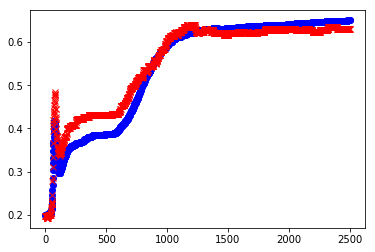

In [16]:
# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

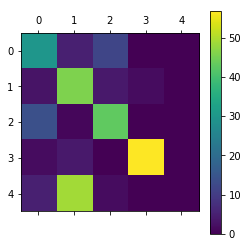

In [17]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

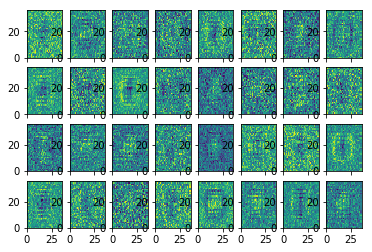

In [18]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))


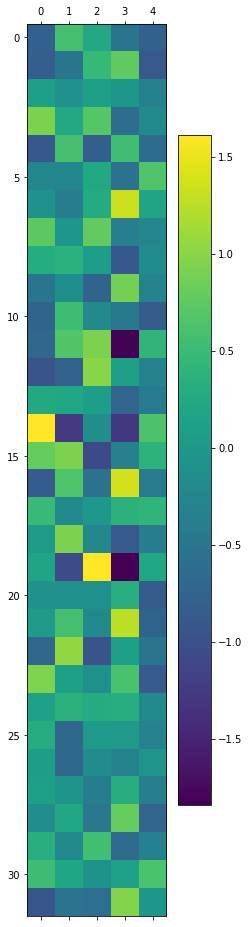

In [19]:
# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

In [20]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "mpl.ckpt")

ValueError: Parent directory of mpl.ckpt doesn't exist, can't save.

In [ ]:
# Restore
saver.restore(sess, "mlp.ckpt")